In [7]:
import hdbscan
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import manifold
import os
import json
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 1000)

In [3]:
MATERIAL_PATH = "../All_mat_new_test_score_with_horz_flat_index.csv"
DATA_PATH = "../../data"

## Start with Anupam's list of materials

In [3]:
material_df = pd.read_csv("../All_mat_new_test_score_with_horz_flat_index.csv", index_col="ID")
print(material_df.shape)
material_df.head()

(5270, 24)


,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,...,D,E,F,radio,f_orb,sg_sto_group,percentage_flat
ID,,,,,,,,,,,,,,,
2dm-1,IrF2,AB2,164,3,0,0.095102,bottom-up,...,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN
2dm-2,Ba2Sb,AB2,164,3,1,0.387410,bottom-up,...,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN
2dm-3,TlS,AB,2,4,4,0.846460,bottom-up,...,NaN,NaN,NaN,non-radioactive,no-f-in-valence,276.0,24.2
2dm-4,MoCl2,AB2,166,5,4,0.713760,bottom-up,...,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN
2dm-6,RuI2,AB2,164,3,1,0.264930,bottom-up,...,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN


In [4]:
# Select flat materials only
flat_df = material_df[material_df.horz_flat_seg > 0]
flat_df.shape

(2005, 24)

## Fingerprint Functions Here
Fingerprint functions take material ID as only input

array([ 0.,  0.,  6., 48., 14., 18., 21.,  5.,  3.,  2., 10., 12., 25.,
       21., 23., 21., 25., 27., 33., 35.,  0.,  0.,  0., 63., 18., 15.,
        9.,  0.,  0.,  0.,  0., 12.,  9., 11., 24., 14., 34., 79., 63.,
       53.,  0.,  0.,  6., 46., 18.,  6., 31.,  6.,  3.,  3., 11., 15.,
       24., 26., 25., 24., 29., 21., 26., 30.])

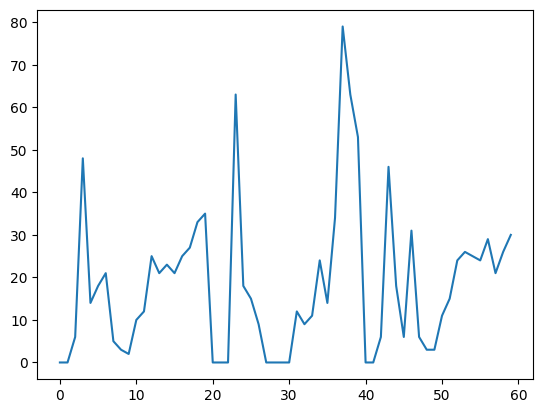

In [109]:
def calc_fingerprint(material_id, fingerprint_length, e_range=[-8, 8]):
    global edges
    filename_bands=DATA_PATH+"/bands/"+material_id+'.json'
    if not os.path.isfile(filename_bands):
        print("!!!! No such file %s" % filename_bands)
    bands_dict=json.load(open(filename_bands))

    fingerprint = np.zeros(fingerprint_length)
    
    k_branches = bands_dict["branches"]
    length_per_branch = fingerprint_length // len(k_branches)

    energies = np.array(bands_dict["bands"]["1"])

    for i, branch in enumerate(k_branches):
        branch_energies = energies[:, branch["start_index"]:branch["end_index"]+1]
        # print(i, branch_energies)
        counts, edges = np.histogram(branch_energies, bins=length_per_branch, range=e_range)
        fingerprint[i*length_per_branch : (i+1)*length_per_branch] = counts
    
    return fingerprint
    

fp = calc_fingerprint("2dm-1", 60)
plt.plot(fp)
fp

In [111]:
fingerprint_length = 60
finger_print_array = np.zeros([len(flat_df), fingerprint_length])

In [112]:
for i, material_id in enumerate(flat_df.index):
    if i % 100 == 0:
        print(i, "/", len(flat_df))

    finger_print_array[i, :] = calc_fingerprint(material_id, fingerprint_length)

print(finger_print_array)

0 / 2005
100 / 2005
200 / 2005
300 / 2005
400 / 2005
500 / 2005
600 / 2005
700 / 2005
800 / 2005
900 / 2005
1000 / 2005
1100 / 2005
1200 / 2005
1300 / 2005
1400 / 2005
1500 / 2005
1600 / 2005
1700 / 2005
1800 / 2005
1900 / 2005
2000 / 2005
[[ 42.   0. 105. ...  17.   0.   0.]
 [ 22.  39.  85. ...  37.   0.   0.]
 [  0.   0.   0. ...   1.   0.   0.]
 ...
 [ 21.  77.  70. ...  55.  68.   6.]
 [146.  64.   0. ...  86.  54.   6.]
 [  0.  10.  53. ...  70.  58.   0.]]


In [117]:
df = flat_df.join(pd.DataFrame(finger_print_array, index=flat_df.index))
df.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,...,53,54,55,56,57,58,59
ID,,,,,,,,,,,,,,,
2dm-3,TlS,AB,2,4,4,0.84646,bottom-up,...,81.0,107.0,169.0,127.0,17.0,0.0,0.0
2dm-21,TaI3,AB3,162,3,3,0.88201,bottom-up,...,63.0,84.0,80.0,115.0,37.0,0.0,0.0
2dm-22,Li2O,AB2,164,3,3,0.96678,bottom-up,...,52.0,45.0,56.0,23.0,1.0,0.0,0.0
2dm-25,VBr4,AB4,123,3,3,0.97834,bottom-up,...,52.0,30.0,0.0,0.0,0.0,0.0,0.0
2dm-29,SBr,AB,2,4,4,0.82037,bottom-up,...,0.0,16.0,136.0,198.0,205.0,33.0,0.0


In [114]:
#check for NaNs 
np.isnan(finger_print_array).sum()

0

In [115]:
df.isna().sum()[ df.isna().sum() != 0 ]

exfoliation_eg     606
decomp_eng          47
B                   10
C                 1124
D                 1752
E                 2005
F                 2005
dtype: int64

In [116]:
# save df
df.to_csv("materials_data_all_k_branches_fingerprint_60.csv")

## Clustering

In [42]:
df = pd.read_csv("materials_data_all_k_branches_fingerprint_60.csv")
fingerprint_length = 60
fingerprint_cols = [str(i) for i in range(fingerprint_length)]
fingerprint_array = df[fingerprint_cols]

clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=40, metric='minkowski', cluster_selection_method='leaf', min_cluster_size=4, min_samples=4, p=0.2)
clusterer.fit(fingerprint_array)

labels = clusterer.labels_
df["labels"] = labels
print(np.unique(labels, return_counts=True))
df[df.labels==1].head(19)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40], dtype=int64), array([1710,    8,    5,   14,    7,    6,    5,    7,    4,    6,    6,
          5,    4,    5,    6,    7,    5,    9,    5,    5,    7,    8,
          9,    6,   11,    9,    4,    5,    5,    6,    4,    4,    8,
          8,   12,    4,   14,    5,    4,    6,   29,    8], dtype=int64))


,ID,formula,gen_formula,space_group,segments,flat_segments,flatness_score,...,54,55,56,57,58,59,labels
233,2dm-900,Ga2Te,AB2,143,3,3,0.78315,...,398.0,224.0,0.0,0.0,0.0,0.0,1
236,2dm-903,Ga2Te,AB2,143,3,3,0.81656,...,390.0,219.0,0.0,0.0,0.0,0.0,1
240,2dm-910,Ga2Se,AB2,143,3,3,0.87920,...,343.0,276.0,0.0,0.0,0.0,0.0,1
522,2dm-1777,Ga2S,AB2,143,3,3,0.87920,...,319.0,309.0,91.0,0.0,0.0,0.0,1
531,2dm-1794,Ga2S,AB2,143,3,3,0.84263,...,331.0,305.0,70.0,0.0,0.0,0.0,1


In [29]:
from ipywidgets import interact

def view_cluster(label):
    display(df[df.labels==label].head(100))

    num_plots = len(df[df.labels==label])

    fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        # ax[i].bar(edges[:-1], df.loc[index][fingerprint_cols], align="edge", width=edges[1]-edges[0])?
        ax[i].plot(np.linspace(-8, 8, fingerprint_length), df.loc[index][fingerprint_cols])


    
    
interact(view_cluster, label=(-1, len(np.unique(labels))-2, 1))

interactive(children=(IntSlider(value=19, description='label', max=40, min=-1), Output()), _dom_classes=('widg…

<function __main__.view_cluster(label)>

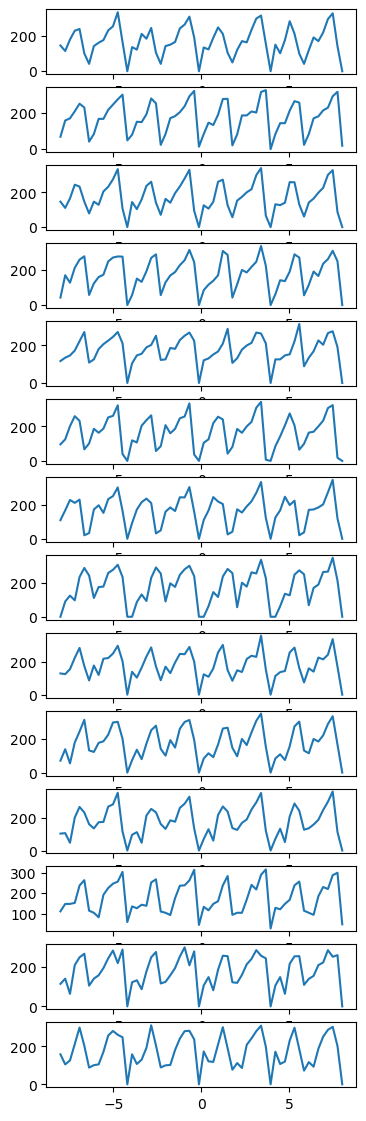

In [4]:
label = 1
num_plots = len(df[df.labels==label])

fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

for i, index in enumerate(df[df.labels==label].index):
    # ax[i].bar(edges[:-1], df.loc[index][fingerprint_cols], align="edge", width=edges[1]-edges[0])?
    ax[i].plot(np.linspace(-8, 8, fingerprint_length), df.loc[index][fingerprint_cols])

plt.show()

## T-SNE Plot

In [19]:
n_components=2
tsne = manifold.TSNE(n_components=n_components, early_exaggeration=12.0, init="pca",learning_rate=100, random_state=0, perplexity=30 ,n_iter=10000, verbose=2)
fingerprints_2d = tsne.fit_transform(fingerprint_array)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2005 samples in 0.001s...
[t-SNE] Computed neighbors for 2005 samples in 0.055s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2005
[t-SNE] Computed conditional probabilities for sample 2000 / 2005
[t-SNE] Computed conditional probabilities for sample 2005 / 2005
[t-SNE] Mean sigma: 151.706942
[t-SNE] Computed conditional probabilities in 0.175s
[t-SNE] Iteration 50: error = 73.4003601, gradient norm = 0.0087247 (50 iterations in 0.481s)
[t-SNE] Iteration 100: error = 72.3757324, gradient norm = 0.0023261 (50 iterations in 0.414s)
[t-SNE] Iteration 150: error = 72.1664429, gradient norm = 0.0005322 (50 iterations in 0.456s)
[t-SNE] Iteration 200: error = 72.1484985, gradient norm = 0.0001829 (50 iterations in 0.430s)
[t-SNE] Iteration 250: error = 72.1472015, gradient norm = 0.0001994 (50 iterations in 0.459s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.147202
[t-SNE] Iteration 300: er

[t-SNE] Iteration 4150: error = 1.1153738, gradient norm = 0.0002531 (50 iterations in 0.556s)
[t-SNE] Iteration 4200: error = 1.1153175, gradient norm = 0.0002463 (50 iterations in 0.571s)
[t-SNE] Iteration 4250: error = 1.1152792, gradient norm = 0.0002196 (50 iterations in 0.559s)
[t-SNE] Iteration 4300: error = 1.1152139, gradient norm = 0.0002628 (50 iterations in 0.571s)
[t-SNE] Iteration 4350: error = 1.1151326, gradient norm = 0.0003000 (50 iterations in 0.530s)
[t-SNE] Iteration 4400: error = 1.1150997, gradient norm = 0.0002306 (50 iterations in 0.590s)
[t-SNE] Iteration 4450: error = 1.1150604, gradient norm = 0.0002114 (50 iterations in 0.578s)
[t-SNE] Iteration 4500: error = 1.1150378, gradient norm = 0.0002255 (50 iterations in 0.542s)
[t-SNE] Iteration 4550: error = 1.1150055, gradient norm = 0.0002676 (50 iterations in 0.628s)
[t-SNE] Iteration 4600: error = 1.1149527, gradient norm = 0.0003330 (50 iterations in 0.554s)
[t-SNE] Iteration 4650: error = 1.1149819, gradien

[t-SNE] Iteration 8500: error = 1.1132050, gradient norm = 0.0001208 (50 iterations in 0.616s)
[t-SNE] Iteration 8550: error = 1.1132178, gradient norm = 0.0000918 (50 iterations in 0.659s)
[t-SNE] Iteration 8600: error = 1.1131855, gradient norm = 0.0001463 (50 iterations in 0.589s)
[t-SNE] Iteration 8650: error = 1.1132112, gradient norm = 0.0001309 (50 iterations in 0.620s)
[t-SNE] Iteration 8700: error = 1.1132064, gradient norm = 0.0001213 (50 iterations in 0.599s)
[t-SNE] Iteration 8750: error = 1.1131899, gradient norm = 0.0000811 (50 iterations in 0.611s)
[t-SNE] Iteration 8800: error = 1.1131732, gradient norm = 0.0001267 (50 iterations in 0.541s)
[t-SNE] Iteration 8850: error = 1.1131252, gradient norm = 0.0000884 (50 iterations in 0.580s)
[t-SNE] Iteration 8900: error = 1.1131620, gradient norm = 0.0000983 (50 iterations in 0.613s)
[t-SNE] Iteration 8950: error = 1.1131307, gradient norm = 0.0001282 (50 iterations in 0.623s)
[t-SNE] Iteration 9000: error = 1.1131157, gradien

C:\Users\hkpen\AppData\Local\Temp\ipykernel_1156\2726245083.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('turbo')


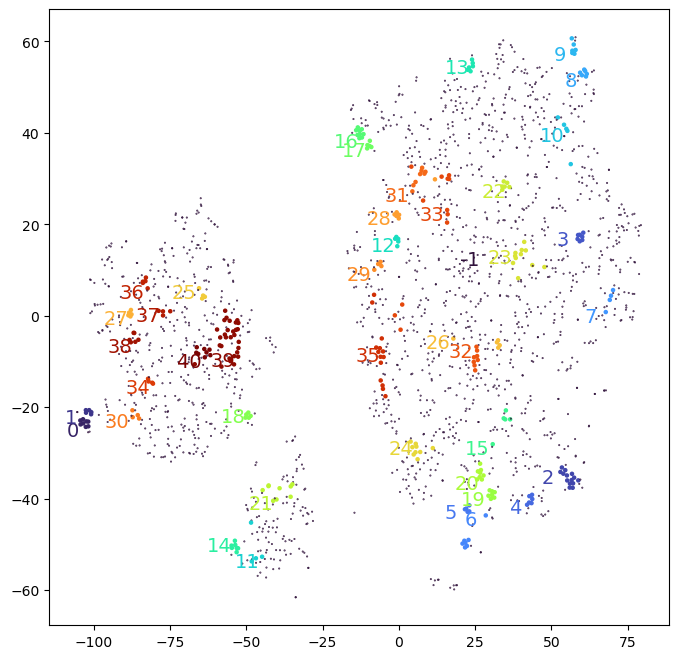

In [53]:
fig = plt.figure(figsize=(8,8))
size=np.ones((len(labels),1))*5
size[labels==-1]=0.2
 
unique_label,cluster_rep_index, counts = np.unique(labels, return_index=True, return_counts=True)
cmap = plt.cm.get_cmap('turbo')
norm = matplotlib.colors.Normalize(vmin=min(labels), vmax=max(labels))
    
for rep_id in cluster_rep_index:
        col=cmap(norm(labels[rep_id]))
        plt.annotate(labels[rep_id],fingerprints_2d[rep_id,:]+[-5,-1],color=col,alpha=1, weight='normal', ha='center', va='center', size=14).draggable()

plt.scatter(fingerprints_2d[:,0], fingerprints_2d[:,1],s=size, c=labels*5, cmap="turbo")